# Acceleration Benchmarks

In this notebook, an initial calculation of the model's inference time is performed. Our goal is to calculate the average inference time for a single step of the model using Pytorch or ONNX run on CPU or GPU. This notebook is run on Intel Core i7 6700 HQ and an Nvidia 965m GPU. More tests will be performed on embedded devices that contitute the main study of the current thesis.

In [55]:
import sys
sys.path.append('../src')
sys.path.append('../../learning/src')

import onnxruntime, torch, logging, joblib, numpy as np
from torchvision import transforms as T
from torch.nn import functional as F 
from utilities import create_environment, time_inference, collect_states, collect_random_states
from collections import deque

logger = logging.getLogger('gym-duckietown')
logger.setLevel(logging.WARNING)

env = create_environment()
states = collect_random_states(3500)

# List to save calculated times
times = []

## Time Pytorch models

Initialy, after isolating the Actor model since it is only the actor needed for the inference part we calculate the average inference time on 3500 random states running the model both on CPU and GPU

In [56]:
class Actor(torch.nn.Module):
    #Implements the inference of only the actor model coming from the acotr critic object

    def __init__(self, 
                actor_critic_model,
                device = 'cpu'):
        #Initilizes actor by copying necesseary layers
        super(Actor, self).__init__()
        self.device = device
        self.conv_core = actor_critic_model.conv_core.to(device)
        self.actor_head = actor_critic_model.actor_head.to(device)
        self.transform = actor_critic_model.transform

    def forward(self, x):
        #Implements forward pass of model 
        x = x.to(device=self.device)
        x = torch.permute(x, (0, 3, 1, 2))   # Place channel axis in correct position
        #x = self.transform(x)               # Apply transform
        x = x / 255
        #x = T.functional.crop(x, top=20, left=0, height=40, width=80)
        x = x[:,:,20:,:]
        #x = x.to(device=self.device)
        visual_repr = self.conv_core(x).squeeze(-1).squeeze(-1)  
        dist = F.log_softmax(self.actor_head(visual_repr), dim=1)
        return dist
    
    def infer_action(self, x):
        # Utilizes torch distributions to return an action
        dist_probs = self.forward(x)
        dist = torch.distributions.Categorical(logits=dist_probs)
        return dist.sample().cpu().numpy()[0]

In [57]:
model = Actor(actor_critic_model=joblib.load('../models/duckieTown_PPO_simple.joblib'), device='cpu')

avg_duration, n_frames = time_inference(states=states, model=model)
times.append(avg_duration)

Average inference time 1.9462281686220586ms calculated on 3500 frames


In [58]:
model = Actor(actor_critic_model=joblib.load('../models/duckieTown_PPO_simple.joblib'), device='cuda')

avg_duration, n_frames = time_inference(states=states, model=model)
times.append(avg_duration)

Average inference time 1.2159393296044854ms calculated on 3500 frames


## Time ONNX models

As the next step, we calculated average inference times on CPU and GPU, this time using the ONNX model. As it can be seen, the ONNX format provides speed up even when we run the model on CPU.

In [59]:
class ONNXActor():
    # Implements actor using ONNX runtime
    
    def __init__(self, onnx_path, providers):
        # Initiliaze model
        self.ort_session = onnxruntime.InferenceSession(onnx_path, providers=providers)
        self.ort_session.disable_fallback()
    
    def forward(self, x):
        # Implements forward pass of model
        output = self.ort_session.run(None, {'input' : x.numpy().astype(np.float32)})[0]
        return torch.Tensor(output)
    
    def infer_action(self, x):
        # Utilizes torch distributions to return an action
        dist_probs = self.forward(x)
        dist = torch.distributions.Categorical(logits=dist_probs)
        return dist.sample().numpy()[0]

In [60]:
model = ONNXActor(onnx_path='../models/actor.onnx', providers=['CPUExecutionProvider'])

avg_duration, n_frames = time_inference(states=states, model=model)
times.append(avg_duration)

Average inference time 0.9529175843843924ms calculated on 3500 frames


In [61]:
model = ONNXActor(onnx_path='../models/actor.onnx', providers=['TensorrtExecutionProvider','CUDAExecutionProvider'])

avg_duration, n_frames = time_inference(states=states, model=model)
times.append(avg_duration)

2022-04-03 22:49:44.666433376 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:509 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.


Average inference time 0.7439031868374774ms calculated on 3500 frames


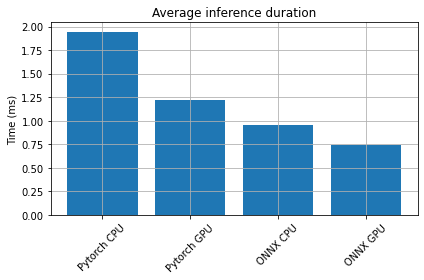

In [67]:
import matplotlib.pyplot as plt

plt.bar(x=range(0, len(times)), height=np.asarray(times)*1000)
plt.ylabel('Time (ms)')
plt.xticks(ticks=range(0, len(times)), labels=['Pytorch CPU', 'Pytorch GPU', 'ONNX CPU', 'ONNX GPU'], rotation=45)
plt.grid()
plt.title('Average inference duration')
plt.tight_layout()
plt.savefig('../results/pytorch_onnx_laptop', dpi=500)